## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Subset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Load Data

In [2]:
def getMNISTDataLoader(batch_size):
    print("Preparing data ...")
    train_subset_indices = np.arange(1000)
    test_subset_indices = np.arange(100)
    transform = transforms.ToTensor()
    trainset = MNIST(root="./data", train=True, download=True, transform=transform)
    testset = MNIST(root="./data", train=False, download=True, transform=transform)
    sub_trainset = Subset(trainset, train_subset_indices)
    sub_testset = Subset(testset, test_subset_indices)
    trainloader = DataLoader(
        sub_trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    testloader = DataLoader(
        sub_testset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    print("Done")
    return trainloader, testloader

In [3]:
batch_size = 128
trainloader, testloader = getMNISTDataLoader(batch_size)

Preparing data ...
Done


## Show random samples in dataset

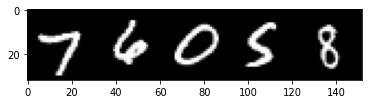

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))

## Functions

In [5]:
def train(model, dataloader, optimizer):
    model.train()
    total_loss = []
    for data in dataloader:
        x, y = data
        _y = model(x)
        loss = model.calc_loss(_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    return np.mean(total_loss)

In [6]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = []
    total_pred = []
    total_y = []
    with torch.no_grad():
        for data in dataloader:
            x, y = data
            _y = model(x)
            loss = model.calc_loss(_y, y)
            total_loss.append(loss.item())
            total_pred += torch.argmax(
                torch.softmax(_y.detach().cpu(), -1), -1
            ).tolist()
            total_y += y.tolist()

    result = {
        "loss": np.mean(total_loss),
        "acc": accuracy_score(total_y, total_pred),
    }
    return result

In [7]:
def print_result(state, result):
    print(f">> {state} <<")
    for k, v in result.items():
        print(f". {k}: {v:.4f}")

In [8]:
def run(model, trainloader, testloader, optimizer, n_epochs):
    train_results = []
    test_results = []
    print("Start Training ...")
    for epoch in range(1, n_epochs + 1):
        avg_loss = train(model, trainloader, optimizer)
        print(f"\nEpoch {epoch}/{n_epochs} avg_loss: {avg_loss:.4f}")
        train_result = evaluate(model, trainloader)
        print_result("train", train_result)
        train_results.append(train_result)
        test_result = evaluate(model, testloader)
        print_result("test", test_result)
        test_results.append(test_result)
    print("\nFinished Training")
    return train_results, test_results

## Model

In [9]:
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()
        self.device = device
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=3 // 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 64, kernel_size=3, padding=3 // 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=3 // 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.to(self.device).float()
        x = self.model(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def calc_loss(self, _y, y):
        return self.loss_fn(_y, y.to(self.device))

## Set parameters

In [10]:
n_epochs = 10
lr = 1e-3

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(device).to(device)
optimizer = Adam(model.parameters(), lr=lr)

## Start training

In [12]:
train_results, test_results = run(model, trainloader, testloader, optimizer, n_epochs)

Start Training ...

Epoch 1/10 avg_loss: 2.2962
>> train <<
. loss: 2.2723
. acc: 0.3050
>> test <<
. loss: 2.2666
. acc: 0.3100

Epoch 2/10 avg_loss: 2.2417
>> train <<
. loss: 2.1729
. acc: 0.4500
>> test <<
. loss: 2.1529
. acc: 0.4600

Epoch 3/10 avg_loss: 2.0704
>> train <<
. loss: 1.8843
. acc: 0.3630
>> test <<
. loss: 1.8742
. acc: 0.4100

Epoch 4/10 avg_loss: 1.6535
>> train <<
. loss: 1.3705
. acc: 0.5550
>> test <<
. loss: 1.3201
. acc: 0.6300

Epoch 5/10 avg_loss: 1.1576
>> train <<
. loss: 0.9699
. acc: 0.6850
>> test <<
. loss: 0.9977
. acc: 0.7000

Epoch 6/10 avg_loss: 0.8370
>> train <<
. loss: 0.7101
. acc: 0.7600
>> test <<
. loss: 0.7914
. acc: 0.7400

Epoch 7/10 avg_loss: 0.6937
>> train <<
. loss: 0.7313
. acc: 0.7710
>> test <<
. loss: 0.8325
. acc: 0.7000

Epoch 8/10 avg_loss: 0.5715
>> train <<
. loss: 0.4885
. acc: 0.8540
>> test <<
. loss: 0.5676
. acc: 0.8000

Epoch 9/10 avg_loss: 0.4479
>> train <<
. loss: 0.4037
. acc: 0.8790
>> test <<
. loss: 0.4342
. acc

## Show results

In [13]:
def plot_results(train_results, test_results):
    train_loss = [epoch_result["loss"] for epoch_result in train_results]
    train_acc = [epoch_result["acc"] for epoch_result in train_results]
    test_loss = [epoch_result["loss"] for epoch_result in test_results]
    test_acc = [epoch_result["acc"] for epoch_result in test_results]
    epoch = np.arange(len(train_results)) + 1
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch, train_loss, label="train")
    plt.plot(epoch, test_loss, label="test")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch, train_acc, label="train")
    plt.plot(epoch, test_acc, label="test")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

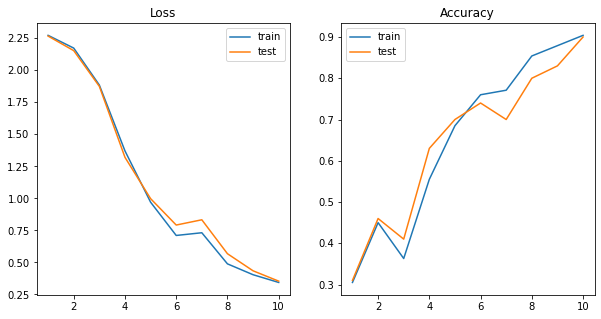

In [14]:
plot_results(train_results, test_results)